This is based on https://towardsdatascience.com/bootstrap-sampling-in-r-a7bc9d3ca14a

In [1]:
# install.packages('tidyverse')
# install.packages('tidymodels')
library(tidyverse)
library(tidymodels)

historical_tuition <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/historical_tuition.csv', show_col_types = FALSE)
head(historical_tuition)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.1.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.2     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

type,year,tuition_type,tuition_cost
<chr>,<chr>,<chr>,<dbl>
All Institutions,1985-86,All Constant,10893
All Institutions,1985-86,4 Year Constant,12274
All Institutions,1985-86,2 Year Constant,7508
All Institutions,1985-86,All Current,4885
All Institutions,1985-86,4 Year Current,5504
All Institutions,1985-86,2 Year Current,3367


In [2]:
# install.packages('janitor')

# %>% represents a pipe operator. 
# Since we are interested in the type of institution, we mutate the dataframe and delete the NAs
tuition_df <- historical_tuition %>% 
  pivot_wider(names_from = type,
              values_from = tuition_cost
              ) %>%
  na.omit() %>% 
  janitor::clean_names()

head(tuition_df)

year,tuition_type,all_institutions,public,private
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1985-86,All Constant,10893,7964,19812
1985-86,4 Year Constant,12274,8604,20578
1985-86,2 Year Constant,7508,6647,14521
1985-86,All Current,4885,3571,8885
1985-86,4 Year Current,5504,3859,9228
1985-86,2 Year Current,3367,2981,6512


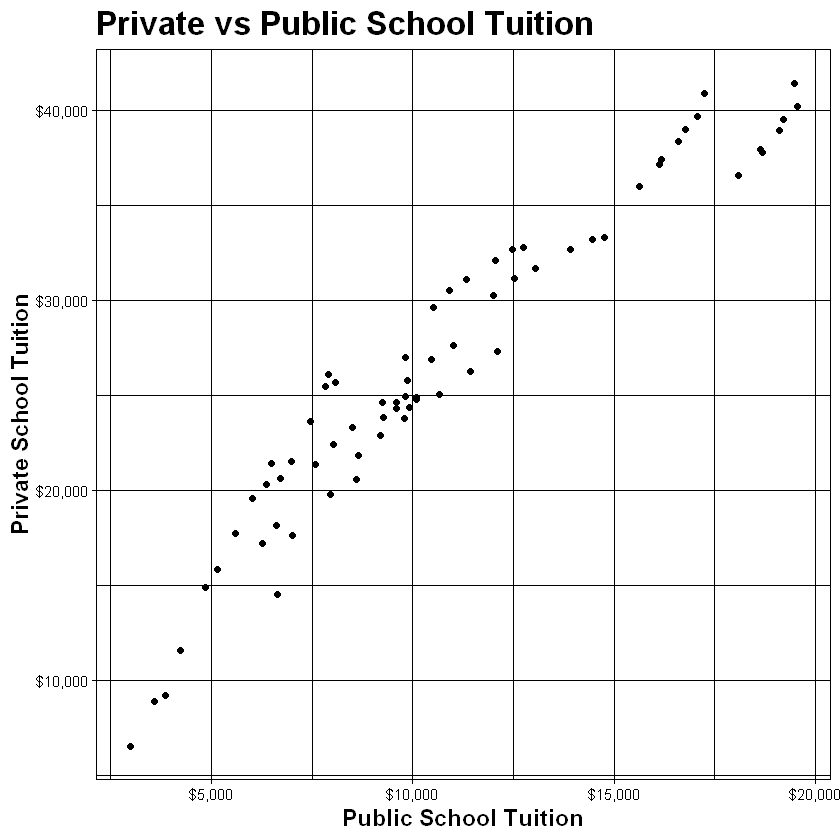

In [3]:
# We visualize the differences between public and private schools
tuition_df %>% 
  ggplot(aes(public, private))+
  geom_point()+
  scale_y_continuous(labels=scales::dollar_format())+
  scale_x_continuous(labels=scales::dollar_format())+
  ggtitle("Private vs Public School Tuition")+
  xlab("Public School Tuition")+
  ylab("Private School Tuition")+
  theme_linedraw()+
  theme(axis.title = element_text(size=14,face="bold"),
        plot.title = element_text(size = 20, face = "bold"))

In [4]:
# We apply a linear fit to quantify the differences between public and private school tuition
tuition_fit <- lm(private ~ 0 + public,
               data = tuition_df)
               
# We tidy the results of the fit
tidy(tuition_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
public,2.378993,0.03460388,68.74933,1.051151e-66


We can see the slope is estimated to be 2.38. For every dollar in tuition spent at a public school a private school is expected to pay around 2.38 times more.

With bootstrapping we will randomly draw with replacement to create new datasets from the original dataset that are the same size as the original. This essentially simulates generating new sets of data from the original set.

In [5]:
set.seed(123)

# This generates 1000 datasets wherein the data is sampled from the original dataset
tuition_boot <- bootstraps(tuition_df,
                          times = 1e3,
                          apparent = TRUE)

Next we will now fit a linear model to the 1,000 re-samplings. These results will be stored in a new column we call model and the statistics will be stored in a column called conf_inf. We will then unnest the results to extract the estimated statistic (slope of the line), errors, and p values.

In [11]:
tuition_models <- tuition_boot %>% 
  # Creates a new array of linear model fits using the data in tuition boot
  mutate(model = map(splits, ~lm(private ~ 0 + public,
               data = .) ),
         # Apply tidy function to model 
         coef_inf = map(model, tidy))

tuition_coefs <- tuition_models %>% 
  unnest(coef_inf)

We now have an added column of estimates for the linear model. The question now arises, what is the distribution of the estimated slope between private and public school tuition using the bootstrapped data?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



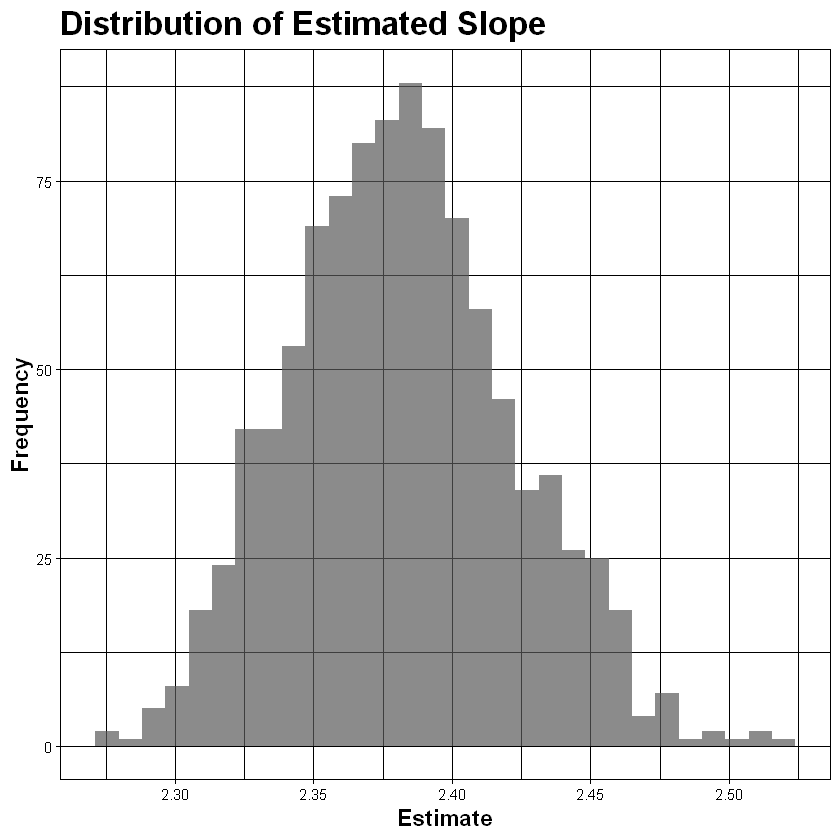

In [13]:
tuition_coefs %>% 
  ggplot(aes(estimate))+
  geom_histogram(alpha = .7)+
  ggtitle("Distribution of Estimated Slope")+
  xlab("Estimate")+
  ylab("Frequency")+
  theme_linedraw()+
  theme(axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 20, face = "bold"))

The data appears normally distributed, we obtain the numerical values below

In [14]:
int_pctl(tuition_models,
         coef_inf)

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
public,2.310044,2.382019,2.461689,0.05,percentile


We can see with bootstrapping the estimated slope that described the relation between private and public school tuition costs is around 2.38–similar to what we obtained without bootstrapping. This could be because the underlying relation between public and private schools is linear and the underlying assumptions of linear models apply to this dataset.

Furthermore, with bootstrapping we have lower and upper bounds for the relation as well which we did not have with just using a linear model on the un-sampled data.

Lastly, we can visualize the various estimates we calculated from the bootstrapped samples.

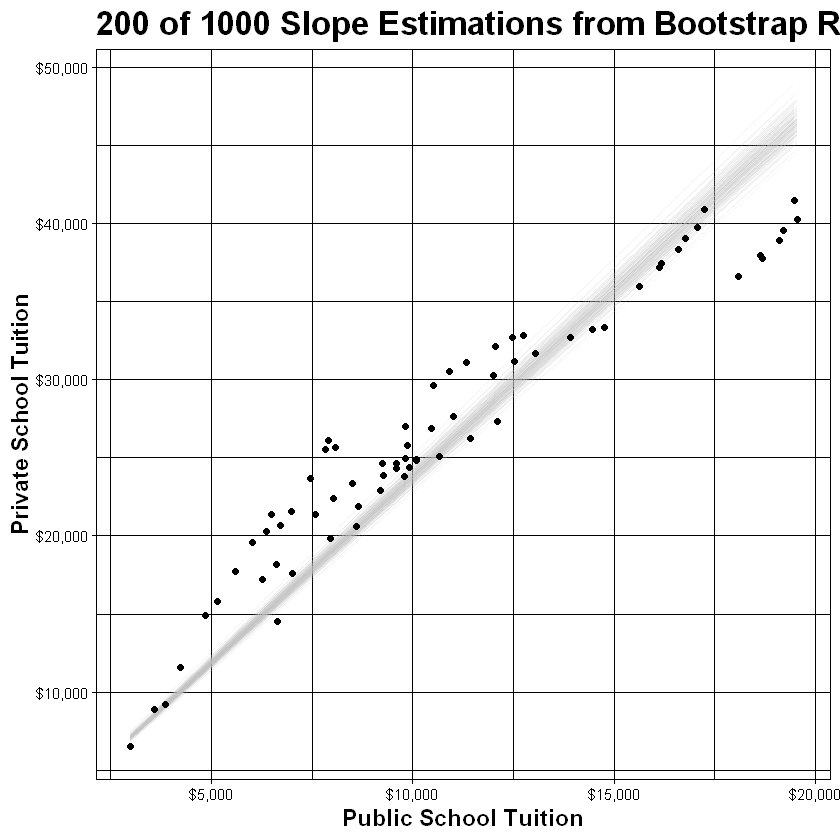

In [16]:
tuition_aug <- tuition_models %>% 
  # Sample only 200 bootstraps for visualization
  sample_n(200) %>% 
  mutate(augmented = map(model, augment)) %>% 
  unnest(augmented)
  
tuition_aug %>% 
  ggplot(aes(public, private))+
  geom_line(aes(y = .fitted, group = id), alpha = .1, color = 'grey')+
  geom_point()+
  scale_y_continuous(labels=scales::dollar_format())+
  scale_x_continuous(labels=scales::dollar_format())+
  ggtitle("200 of 1000 Slope Estimations from Bootstrap Resampling")+
  xlab("Public School Tuition")+
  ylab("Private School Tuition")+
  theme_linedraw()+
  theme(axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 20, face = "bold"))